In [2]:
import os
import glob
import random
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset
import imgaug.augmenters as iaa
import matplotlib.pyplot as plt

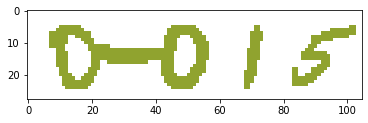

In [7]:

pic_up = cv2.imread("data/1.png")
plt.imshow(pic_up)

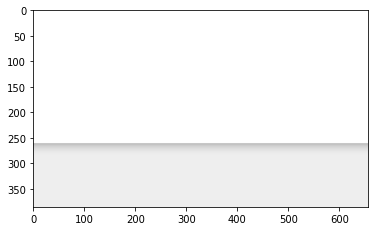

In [48]:
pic_back = cv2.imread("0.png")
plt.imshow(pic_back)

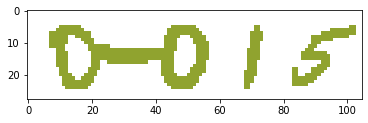

In [18]:
def my_aug_up(img):
    seq = iaa.Sequential([
        iaa.Fliplr(0.5),
    ])
    imgs = np.expand_dims(img,0)
    imgs = seq.augment_images(imgs) 
    return imgs[0]

pic = my_aug_up(pic_up)
plt.imshow(pic)

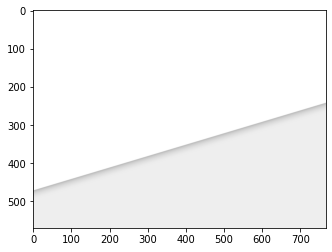

In [31]:
def my_aug_back(img):
    seq = iaa.Sequential([
        iaa.Fliplr(0.5),
        iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
            translate_percent={"x": (-0.5, 0.5), "y": (-0.5, 0.5)},
            rotate=(-10, 10),
            shear=(-15, 15),
            order=[0, 1],  # use nearest neighbour or bilinear interpolation (fast)
            fit_output=True,
            cval=255,# if mode is constant, use a cval between 0 and 255
            mode='edge'
        ),
    ], random_order=True)
    
    imgs = np.expand_dims(img,0)
    imgs = seq.augment_images(imgs) 
    return imgs[0]

pic = my_aug_back(pic_back)
plt.imshow(pic)

In [33]:
def cal_iou(bbox1, bbox2):
    cx1, cy1, cx2, cy2 = bbox1
    gx1, gy1, gx2, gy2 = bbox2

    carea = (cx2 - cx1 + 1) * (cy2 - cy1 + 1)  # C\B5\C4\C3\E6\BB\FD
    garea = (gx2 - gx1 + 1) * (gy2 - gy1 + 1)  # G\B5\C4\C3\E6\BB\FD

    x1 = max(cx1, gx1)
    y1 = max(cy1, gy1)
    x2 = min(cx2, gx2)
    y2 = min(cy2, gy2)
    w = max(0, x2 - x1 + 1)
    h = max(0, y2 - y1 + 1)
    area = w * h  # C\A1\C9G\B5\C4\C3\E6\BB\FD
    iou = area / (carea + garea - area)
    return iou

In [45]:
def merge(scale_fit, imgt, imgb, bboxes=[], tryTimes=10):
    bboxes = np.array(bboxes)
    ht, wt, _ = imgt.shape  # top
    hb, wb, _ = imgb.shape  # bottom

    wtr = int(wt * scale_fit)
    htr = int(ht * scale_fit)
    imgtr = cv2.resize(imgt, (wtr, htr), interpolation=cv2.INTER_AREA)

    if len(bboxes) == 0:
        x0 = random.randint(0, wb - wtr)
        y0 = random.randint(0, hb - htr)
        bboxNew = np.array([x0, y0, x0 + wtr, y0 + htr])
        bboxes = np.array([bboxNew])

        imgbCut = imgb[y0:y0 + htr, x0:x0 + wtr]
        imgtr[imgtr == 255] = imgbCut[imgtr == 255]
        # imgb[y0:y0 + htr, x0:x0 + wtr] = cv2.addWeighted(imgtr, bright, imgbCut, 1 - bright, 0)
        imgb[y0:y0 + htr, x0:x0 + wtr] = imgtr
        return imgb, bboxes

    for i in range(tryTimes):
        x0 = random.randint(0, wb - wtr)
        y0 = random.randint(0, hb - htr)
        bboxNew = np.array([x0, y0, x0 + wtr, y0 + htr])
        for bbox in bboxes:
            iou = cal_iou(bbox, bboxNew)
            if iou > 0:
                break
        if i == tryTimes - 1:
            return imgb, bboxes
        if iou <= 0:
            bboxes = np.row_stack([bboxes, bboxNew])
            imgbCut = imgb[y0:y0 + htr, x0:x0 + wtr]
            imgtr[imgtr == 255] = imgbCut[imgtr == 255]
            # imgb[y0:y0 + htr, x0:x0 + wtr] = cv2.addWeighted(imgtr, bright, imgbCut, 1 - bright, 0)
            imgb[y0:y0 + htr, x0:x0 + wtr] = imgtr
            return imgb, bboxes

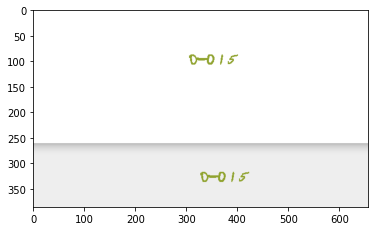

In [50]:
pic_back, boxes = merge(scale_fit=1.0, imgt=pic_up, imgb=pic_back, bboxes=boxes)
plt.imshow(pic_back)

[[511  11 616  39]
 [117 189 222 217]
 [299  82 404 110]
 [321 312 426 340]]


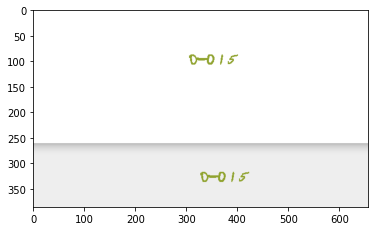

In [51]:
plt.imshow(pic_back)
print(boxes)